In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

## Evaluation

In [2]:
"https://medium.com/towards-data-science/mean-average-precision-at-k-map-k-clearly-explained-538d8e032d2"
def apk(y_true, y_pred, k_max=0):
  # Check if all elements in lists are unique
  if len(set(y_true)) != len(y_true):
    raise ValueError("Values in y_true are not unique")

  if len(set(y_pred)) != len(y_pred):
    raise ValueError("Values in y_pred are not unique")
  if len(set(y_true)) == 0:
    return 0
  if k_max != 0:
    y_pred = y_pred[:k_max]

  correct_predictions = 0
  running_sum = 0

  for i, yp_item in enumerate(y_pred):

    k = i + 1 # our rank starts at 1

    if yp_item in y_true:
      correct_predictions += 1
      running_sum += correct_predictions/k

  return running_sum/len(y_true)

In [3]:
def make_evaluation(joined_sheet_results,sheet_names_filtered):
    results = []
    first_relevant = None
    for annotated_sheet,sheet_name in zip(joined_sheet_results,sheet_names_filtered):
        for index, result in enumerate(annotated_sheet, start=1):
            if result["relevant"] == True:
                first_relevant = index
                break
        pred = [x["jobtitle"] for x in annotated_sheet]
        true_vals =  [x["jobtitle"] for x in annotated_sheet if x["relevant"]==True]
        try:
            PRECISION_AT_20 = (len(true_vals)/len(pred))
        except ZeroDivisionError:
            PRECISION_AT_20 = 0

        APK_AT_20 = apk(true_vals,pred)
        if first_relevant != None:
            RR = 1/first_relevant
        else:
            RR = 0
        results.append({"sheetname": sheet_name,"P_20":PRECISION_AT_20,"AP_20":APK_AT_20,"RR":RR})
    return pd.DataFrame(results)

In [4]:
def evaluate_filtered_df(filtered_df):
    first_relevant = None
    filtered_df_list = filtered_df.to_dict("records")
    for index, result in enumerate(filtered_df_list, start=1):
        if result["relevant"] == True:
            first_relevant = index
            break
    pred = [x["jobtitle"] for x in filtered_df_list]
    true_vals =  [x["jobtitle"] for x in filtered_df_list if x["relevant"]==True]
    try:
        PRECISION_AT_20 = (len(true_vals)/len(pred))
    except ZeroDivisionError:
        PRECISION_AT_20 = 0

    APK_AT_20 = apk(true_vals,pred)
    #print(APK_AT_20)
    if first_relevant != None:
        RR = 1/first_relevant
    else:
        RR = 0
    results = {"P@20":PRECISION_AT_20,"MAP@20":APK_AT_20,"MRR@20":RR}
    return results

In [5]:
def calculate_metrics(df):
    metrics_df = []
    for model in df["model"].unique():
        for cv in df["CV"].unique():

            df_filtered = df[(df["model"]==model) & (df["CV"]==cv)]
            metrics = {}
            metrics.update({"model": model, "CV": cv})
            metrics.update(evaluate_filtered_df(df_filtered))
            metrics_df.append(metrics)
    metrics_df = pd.DataFrame(metrics_df).round(3)
    return metrics_df

## Preprocesing

In [ ]:
# def join_model_name(sheetname, current_cv_predictions):
#     model_lookup = current_cv_predictions.parse("model_lookup", index_col=0).to_dict()[0]
#     return model_lookup[sheetname.split("_")[0]].split("_")[0]

In [6]:
def join_model_name(sheetname, current_cv_predictions):
    model_lookup = current_cv_predictions.parse("model_lookup", index_col=0).to_dict()[0]
    tfidf = "_".join(sheetname.split("_")[1:])
    bertmodel = model_lookup[sheetname.split("_")[0]].split("_")[0]
    return "_".join([bertmodel,tfidf])

# Main

In [7]:
user_evaluations = [f"../00_data/CV_Evaluation/user_answers/{x}" for x in os.listdir("../00_data/CV_Evaluation/user_answers/") if "evaluation" in x]
user_evaluations

FileNotFoundError: ignored

In [ ]:
#get data that has "CV", jobtitle and a percentage of how many users have rated thejob as relevant
relevance_evaluation = []
for evaluation in user_evaluations:
    # open user evaluation
    eval_results = pd.ExcelFile(evaluation)
    for cv_name in eval_results.sheet_names:
    # get the relevant job titles of the user
        results_cv = (eval_results.parse(cv_name, index_col=0))
       # results_cv["relevant_absolute"] = np.where(results_cv["relevant"]==True,1,0)
        results_cv["CV"] = cv_name
        relevance_evaluation.append(results_cv)

relevance_evaluation = pd.concat(relevance_evaluation).groupby(["CV","jobtitle"]).sum().reset_index()
relevance_evaluation["relevant_relative"] = round(relevance_evaluation["relevant"]/len(user_evaluations),2)

In [ ]:
#transfrom the dataframe to a dictionary with all jobtitles per CV, which have been considered relevant by [threshold] users.
# e.g. if threshold = 0.5 : Dictionary of jobs, which have been considered relevant from min. 50% of users
threshold = 0.5
relevance_evaluation["relevant"] = np.where(relevance_evaluation["relevant_relative"]>=threshold,True,False)


relevant_jobs = (relevance_evaluation[relevance_evaluation["relevant_relative"]>=threshold])
list_cvs = list(relevant_jobs.groupby("CV"))
relevance_dict = {x[0]:list(x[1]["jobtitle"]) for x in list_cvs}
len(relevance_dict["CV_5"])

18

In [ ]:
# relevance_evaluation[relevance_evaluation["CV"]=="CV_2"].sort_values(by="relevant",ascending=False)

{'CV_1': 35, 'CV_2': 45, 'CV_3': 29, 'CV_4': 29, 'CV_5': 33}


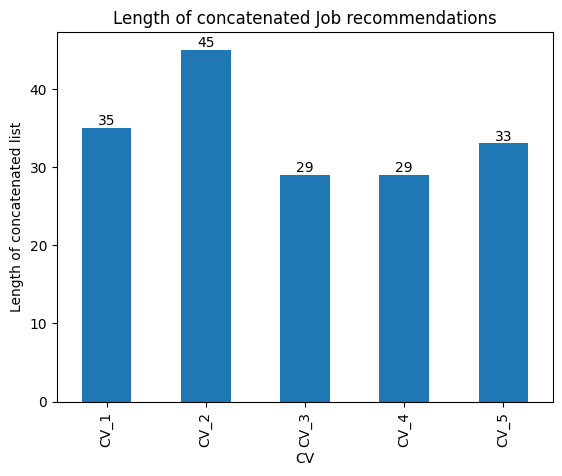

In [ ]:
unique_proposals = {}
for i in range(1,6):
    list_proposals = list(pd.read_excel(f"../00_data/CV_Evaluation/results/CV_{i}.xlsx",sheet_name="concat",index_col=0)["jobtitle"])
    unique_proposals[f"CV_{i}"] = len(list_proposals)
print(unique_proposals)
ax = pd.DataFrame([unique_proposals.keys(),unique_proposals.values()],index=["CV","proposed jobs"]).T
ax = ax.plot(kind="bar", x="CV", legend=False, ylabel="Length of concatenated list",title="Length of concatenated Job recommendations")
ax = ax.bar_label(ax.containers[0])

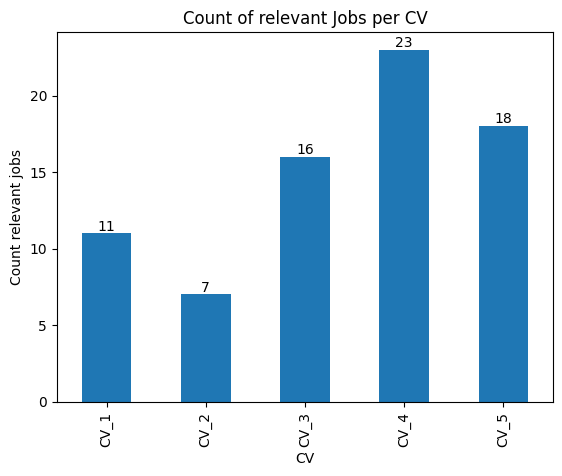

In [ ]:
len_relevant = [len(x) for x in relevance_dict.values()]
ax = pd.DataFrame([relevance_dict.keys(),len_relevant],index=["CV","relevant items"]).T
ax = ax.sort_values(by="CV",ascending=True).plot(kind="bar",x="CV",ylabel="Count relevant jobs",
 title = "Count of relevant Jobs per CV",
 legend=False)
ax = ax.bar_label(ax.containers[0])

In [ ]:
relative_relevant_dict = {}
for k, v in relevance_dict.items():
    relative_relevant_dict[k] = round(len(v)/unique_proposals[k],3)
relative_relevant_dict

{'CV_1': 0.314, 'CV_2': 0.156, 'CV_3': 0.552, 'CV_4': 0.793, 'CV_5': 0.545}

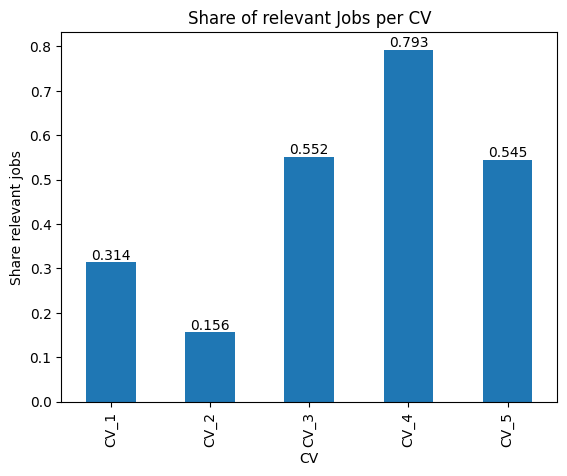

In [ ]:
ax = pd.DataFrame([relative_relevant_dict.keys(),relative_relevant_dict.values()],index=["CV","relevant items"]).T
ax = ax.sort_values(by="CV",ascending=True).plot(kind="bar",x="CV",ylabel="Share relevant jobs",
 title = "Share of relevant Jobs per CV", legend=False)
ax = ax.bar_label(ax.containers[0])

<Axes: >

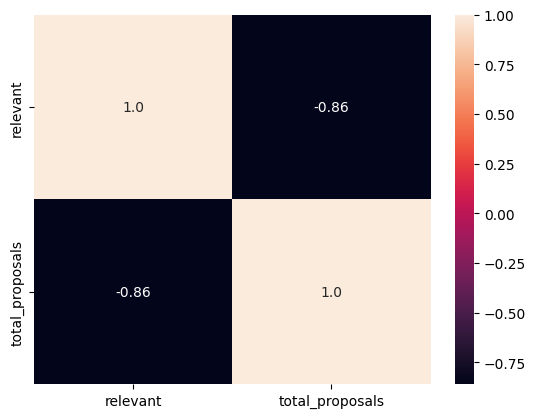

In [ ]:
data = pd.DataFrame([relative_relevant_dict.keys(),
                   len_relevant,unique_proposals.values(),
                   #relative_relevant_dict.values()
                   ],
                   index=["CV","relevant","total_proposals",
                          #"relative"
                          ]).T
data = data.set_index("CV")
data = data.astype(float)
sns.heatmap(data.corr().round(2),fmt="", annot=True)

Axes(0.547727,0.11;0.352273x0.77)


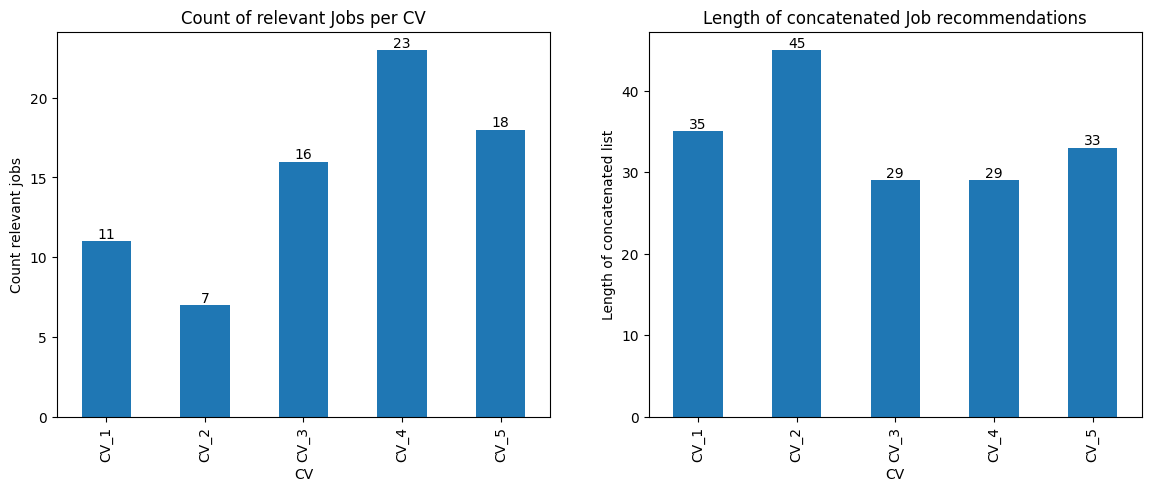

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,5))

ax_1 = pd.DataFrame([relevance_dict.keys(),len_relevant],index=["CV","relevant items"]).T
ax_1 = ax_1.sort_values(by="CV",ascending=True).plot(kind="bar",x="CV",ylabel="Count relevant jobs",
title = "Count of relevant Jobs per CV",legend=False,ax=axes[0])
for container in ax_1.containers:
    ax_1.bar_label(container)

ax_2 = pd.DataFrame([unique_proposals.keys(),unique_proposals.values()],index=["CV","proposed jobs"]).T
ax_2 = ax_2.plot(kind="bar", x="CV", legend=False, ylabel="Length of concatenated list",title="Length of concatenated Job recommendations",ax=axes[1])
print(ax_2)
ax_2 = ax_2.bar_label(ax_2.containers[0])

In [ ]:
total_evaluation = []
for cv_name in ["CV_1","CV_2","CV_3","CV_4","CV_5"]:
    prediction_results = pd.ExcelFile(f"../00_data/CV_Evaluation/results/{cv_name}.xlsx")

    model_predictions = [x for x in prediction_results.sheet_names if x not in ["concat", "model_lookup"]]
    for model in model_predictions:
        df = prediction_results.parse(model, index_col=0)
        relevant_for_cv = relevance_dict[cv_name]
        df["relevant"] = np.where(df["jobtitle"].isin(relevant_for_cv),True,False)
        df["CV"] = cv_name
        #df["model"] = model
        df["model"] = join_model_name(model,prediction_results)
        total_evaluation.append(df)
total_evaluation = pd.concat(total_evaluation).reset_index(drop=True)
total_evaluation = total_evaluation[total_evaluation["CV"]!="CV_2"]

In [ ]:
total_evaluation.replace("jobgbert_w_tfidf", "JobGBERT_w_TFIDF",inplace=True)
total_evaluation.replace("jobgbert_wo_tfidf", "JobGBERT_wo_TFIDF",inplace=True)

total_evaluation.replace("gbert_w_tfidf", "GBERT_w_TFIDF",inplace=True)
total_evaluation.replace("gbert_wo_tfidf", "GBERT_wo_TFIDF",inplace=True)

In [ ]:
# simdf = total_evaluation[["CV","similarity"]].groupby("CV").mean().reset_index()
# simdf = pd.merge(simdf,pd.DataFrame([relative_relevant_dict.keys(),relative_relevant_dict.values()],index=["CV","relevant items"]).T)
# simdf.set_index("CV",inplace=True)
# display(simdf)
# sns.heatmap(simdf.astype(float).corr().round(2),annot=True,fmt="")

In [ ]:
# total_evaluation[(total_evaluation["CV"]=="CV_3") & (total_evaluation["model"]=="GBERT_wo_TFIDF") ]

In [ ]:
metrics_df = calculate_metrics(total_evaluation)
metrics_df["tfidf"] = np.where(metrics_df["model"].str.contains("wo"), False, True)

P@20


C:\Users\lw\AppData\Local\Temp\ipykernel_14092\3328030668.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = (metrics_df.groupby(["model","CV"]).mean(numeric_only=True)).reset_index().pivot("CV","model",values=metric).plot(figsize=(10,5),kind="barh",xlabel=metric)


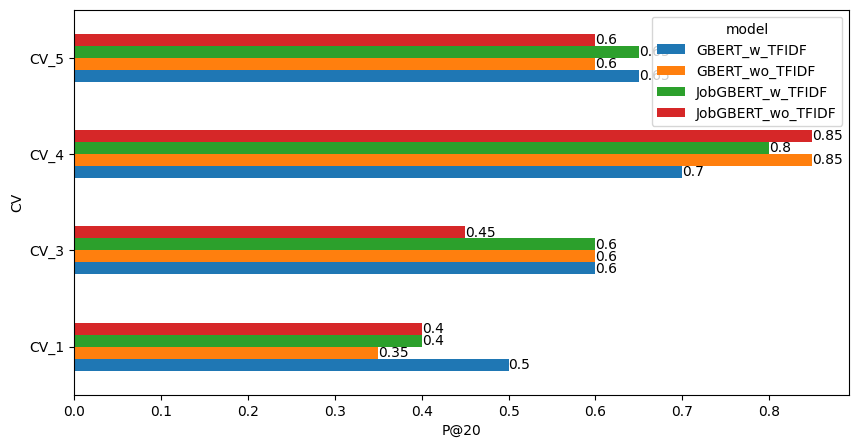

In [ ]:
metric = "P@20"
print(metric)
ax = (metrics_df.groupby(["model","CV"]).mean(numeric_only=True)).reset_index().pivot("CV","model",values=metric).plot(figsize=(10,5),kind="barh",xlabel=metric)
for container in ax.containers:
    ax.bar_label(container)

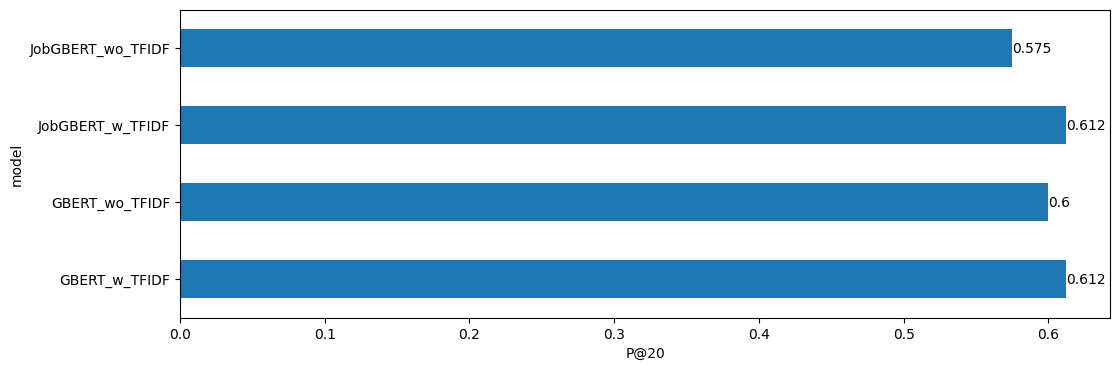

In [ ]:
ax = (metrics_df.groupby(["model"]).mean(numeric_only=True)).round(3).reset_index().plot(kind="barh",
                                                                                y=metric,xlabel=metric,
                                                                                  x="model",legend=False,
                                                                                  figsize= (12,4))
for container in ax.containers:
    ax.bar_label(container)

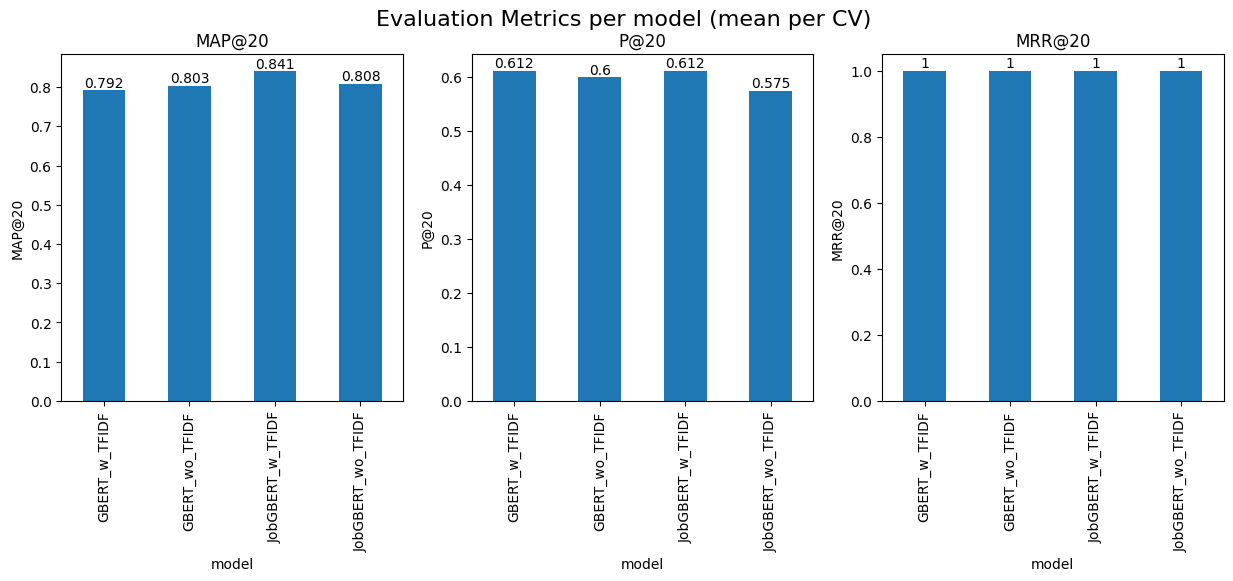

In [ ]:
#dimension can be model or CV (or tfidf)
dimension = "model"

if dimension =="CV":
    mean_by = "model"
elif dimension == "tfidf":
    mean_by = "CV and model"
else:
    mean_by = "CV"

metrics = ["MAP@20","P@20","MRR@20"]

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4.5))
fig.suptitle(f'Evaluation Metrics per {dimension} (mean per {mean_by})', fontsize = 16)
for index, metric in enumerate(metrics):
    ax = metrics_df.groupby([dimension]).mean(numeric_only=True).round(3).reset_index().plot(kind="bar", y=metric, ylabel=metric,
                                                                                    x=dimension,ax=axes[index], legend=False, title = metric)
    for container in ax.containers:
        ax.bar_label(container)

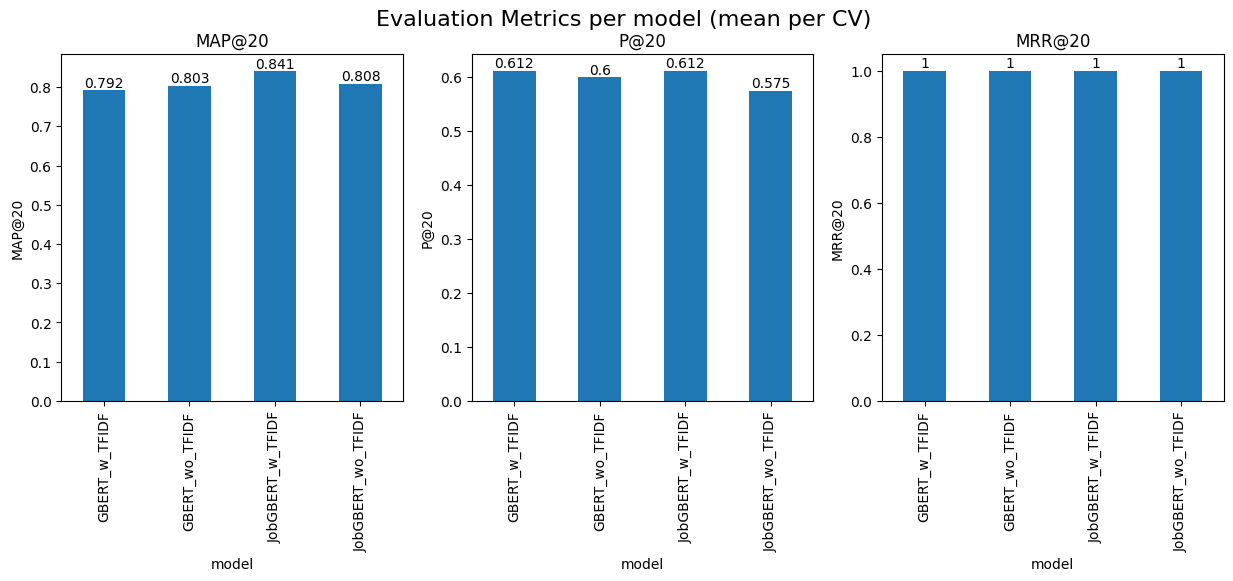

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4.5))
fig.suptitle(f'Evaluation Metrics per {dimension} (mean per {mean_by})', fontsize = 16)
for index, metric in enumerate(metrics):
    ax = metrics_df.groupby([dimension]).mean(numeric_only=True).round(3).reset_index().plot(kind="bar", y=metric, ylabel=metric,
                                                                                    x=dimension,ax=axes[index], legend=False, title = metric)
    for container in ax.containers:
        ax.bar_label(container)

C:\Users\lw\AppData\Local\Temp\ipykernel_14092\539462640.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = metrics_df.groupby("model").mean().round(3).plot(kind="barh")


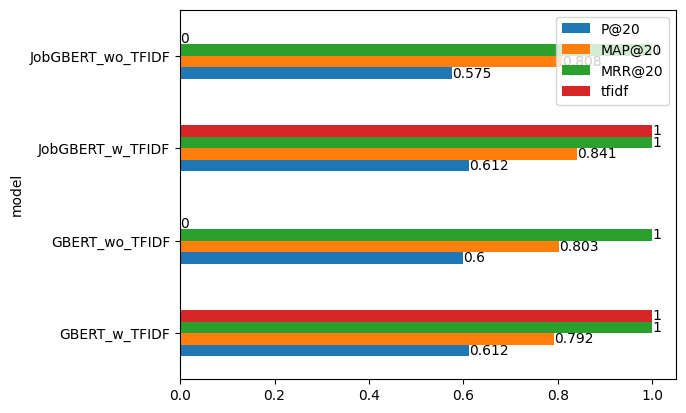

In [ ]:
ax = metrics_df.groupby("model").mean().round(3).plot(kind="barh")
for container in ax.containers:
    ax.bar_label(container)

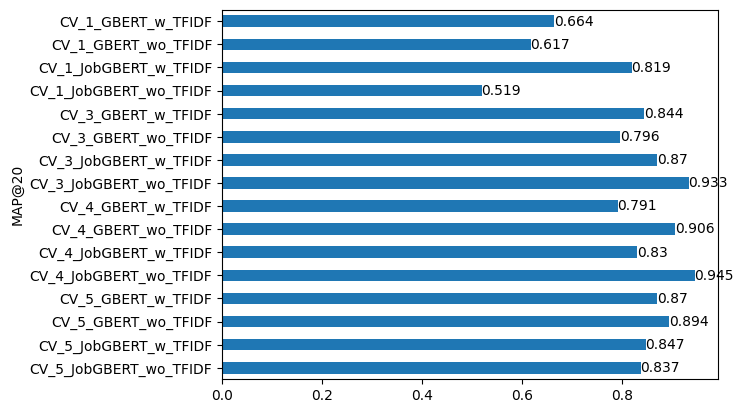

In [ ]:
metric="MAP@20"
dimension = ["CV", "model"]

ax = metrics_df.groupby(dimension).mean(numeric_only=True).reset_index()
ax["name"] = ax["CV"]+"_"+ax["model"]
ax = ax.sort_values(by="name",ascending=False).plot(kind="barh", y=metric, ylabel=metric,legend=False,x="name")
for container in ax.containers:
    ax.bar_label(container)